## Prophet-based time series forecasting model

19:03:44 - cmdstanpy - INFO - Chain [1] start processing
19:03:44 - cmdstanpy - INFO - Chain [1] done processing


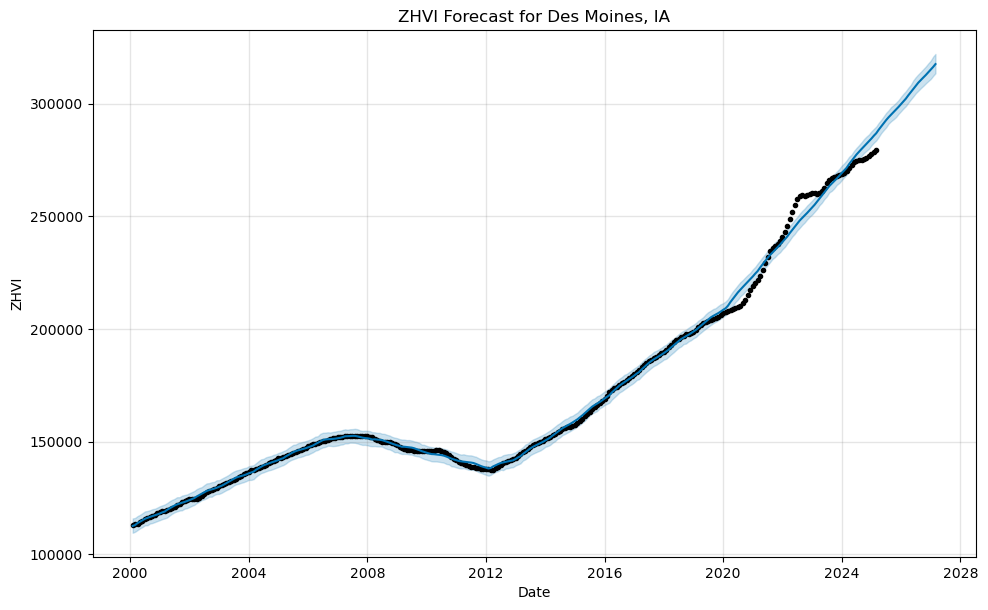

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

df = pd.read_csv("reshaped_zillow.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['RegionName', 'Date'])

df_dsm = df[df['RegionName'] == 'Des Moines, IA'][['Date', 'ZHVI']].dropna()
df_dsm = df_dsm.rename(columns={'Date': 'ds', 'ZHVI': 'y'})

model = Prophet()
model.fit(df_dsm)

future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title("ZHVI Forecast for Des Moines, IA")
plt.xlabel("Date")
plt.ylabel("ZHVI")
plt.grid(True)
plt.show()


### Prophet-based time series forecasting model 
#### Loop Over Multiple cities data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import os

df = pd.read_csv("reshaped_zillow.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['RegionName', 'Date'])

os.makedirs("Forecast_Images", exist_ok=True)

unique_cities = df['RegionName'].value_counts().head(10).index  # Change 10 to all with: df['RegionName'].unique()

for city in unique_cities:
    city_df = df[df['RegionName'] == city][['Date', 'ZHVI']].dropna()

    if len(city_df) < 24:
        continue  # Skip if too few data points

    city_df = city_df.rename(columns={'Date': 'ds', 'ZHVI': 'y'})

    model = Prophet()
    model.fit(city_df)

    future = model.make_future_dataframe(periods=24, freq='M')
    forecast = model.predict(future)

    fig = model.plot(forecast)
    plt.title(f"ZHVI Forecast - {city}")
    plt.xlabel("Date")
    plt.ylabel("ZHVI")
    plt.grid(True)
    plt.tight_layout()

    filename = f"Forecast_Images/{city.replace(',', '').replace(' ', '_')}.png"
    fig.savefig(filename)
    plt.close(fig)

    print(f"Forecast completed for: {city}")


14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing
14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing


Forecast completed for: Aberdeen, SD
Forecast completed for: Olean, NY


14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing
14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing


Forecast completed for: Norwalk, OH


14:42:24 - cmdstanpy - INFO - Chain [1] start processing
14:42:24 - cmdstanpy - INFO - Chain [1] done processing


Forecast completed for: Norwich, CT


14:42:24 - cmdstanpy - INFO - Chain [1] start processing
14:42:24 - cmdstanpy - INFO - Chain [1] done processing


Forecast completed for: Oak Harbor, WA


14:42:24 - cmdstanpy - INFO - Chain [1] start processing
14:42:24 - cmdstanpy - INFO - Chain [1] done processing


Forecast completed for: Ocala, FL
Forecast completed for: Ocean City, NJ


14:42:24 - cmdstanpy - INFO - Chain [1] start processing
14:42:24 - cmdstanpy - INFO - Chain [1] done processing
14:42:24 - cmdstanpy - INFO - Chain [1] start processing
14:42:25 - cmdstanpy - INFO - Chain [1] done processing


Forecast completed for: Odessa, TX
Forecast completed for: Ogden, UT


14:42:25 - cmdstanpy - INFO - Chain [1] start processing
14:42:25 - cmdstanpy - INFO - Chain [1] done processing


Forecast completed for: Ogdensburg, NY


## Supervised Machine Learning – Predicting ZHVI Using Features

#### Data Preparation (Preparing Zillow file for ML)

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("reshaped_zillow.csv")
df['Date'] = pd.to_datetime(df['Date'])  # Make sure 'Date' is datetime type

df.sort_values(['RegionName', 'Date'], inplace=True)

df['ZHVI_lag1'] = df.groupby('RegionName')['ZHVI'].shift(1)
df['ZHVI_lag2'] = df.groupby('RegionName')['ZHVI'].shift(2)
df['ZHVI_lag3'] = df.groupby('RegionName')['ZHVI'].shift(3)
df['ZHVI_roll3'] = df.groupby('RegionName')['ZHVI'].transform(lambda x: x.rolling(3).mean())

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

df = df.dropna(subset=['ZHVI', 'ZHVI_lag1', 'ZHVI_lag2', 'ZHVI_lag3', 'ZHVI_roll3'])

df = pd.get_dummies(df, columns=['State'], drop_first=True)

features = ['ZHVI_lag1', 'ZHVI_lag2', 'ZHVI_lag3', 'ZHVI_roll3', 'SizeRank', 'Year', 'Month']
features += [col for col in df.columns if col.startswith('State_')]

X = df[features]
y = df['ZHVI']

df.to_csv("prepared_ml_zillow_data.csv", index=False)


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("prepared_ml_zillow_data.csv")

print("Data loaded. Shape:", df.shape)

df_sample = df.sample(n=20000, random_state=42)

features = ['ZHVI_lag1', 'ZHVI_lag2', 'ZHVI_lag3', 'ZHVI_roll3', 'SizeRank', 'Year', 'Month']
state_cols = [col for col in df_sample.columns if col.startswith("State_")]
X = df_sample[features + state_cols]
y = df_sample['ZHVI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)

print("Training Random Forest model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Model training completed.")

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n Evaluation Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


Data loaded. Shape: (217472, 63)
Training set size: (16000, 57)
Training Random Forest model...
Model training completed.

✅ Evaluation Results:
MAE: 531.76
RMSE: 2076.59
R²: 0.9997


## Clustering Analysis for Market Typing

/Users/rajatjhawar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


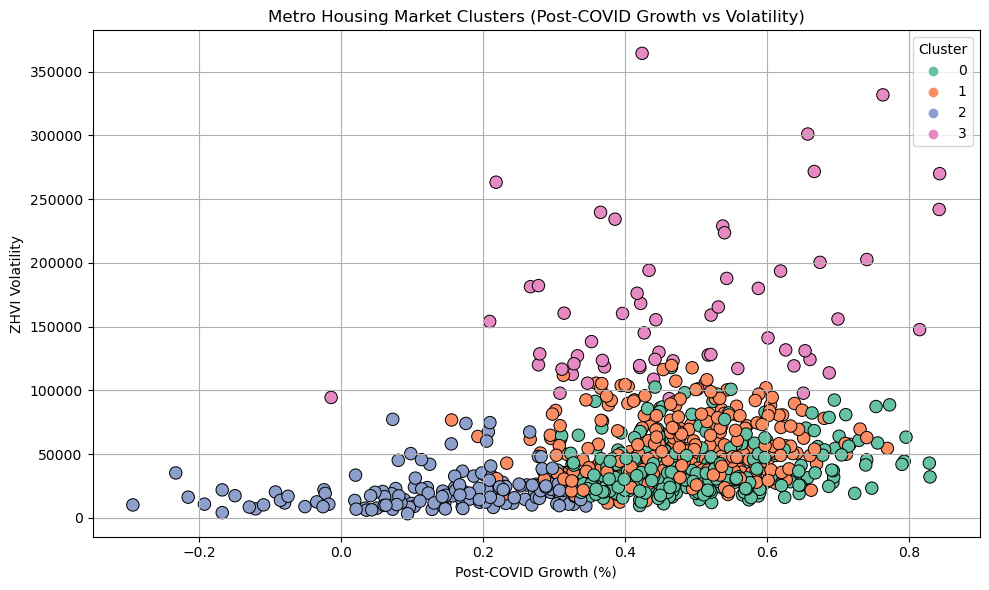


🔹 Cluster 0 Sample Cities:
['Ada, OK', 'Alamogordo, NM', 'Albemarle, NC', 'Albert Lea, MN', 'Alexandria, MN']

🔹 Cluster 1 Sample Cities:
['Aberdeen, WA', 'Abilene, TX', 'Adrian, MI', 'Akron, OH', 'Albany, GA']

🔹 Cluster 2 Sample Cities:
['Aberdeen, SD', 'Alexandria, LA', 'Alice, TX', 'Alma, MI', 'Altoona, PA']

🔹 Cluster 3 Sample Cities:
['Barnstable Town, MA', 'Bellingham, WA', 'Bend, OR', 'Boston, MA', 'Boulder, CO']


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("reshaped_zillow.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['ZHVI'])  # Dropping rows where ZHVI is missing

pivoted = df.pivot_table(index='RegionName', columns='Date', values='ZHVI')
available_dates = pivoted.columns
target_march = pd.to_datetime("2020-03-31")
closest_march = available_dates[available_dates.get_indexer([target_march], method='nearest')[0]]
latest_date = available_dates.max()

# A. Post-COVID Growth
post_covid_growth = (
    (pivoted[latest_date] - pivoted[closest_march]) / pivoted[closest_march]
).rename("Post_COVID_Growth")

# B. Volatility: Standard deviation of ZHVI per region
volatility = df.groupby("RegionName")["ZHVI"].std().rename("Volatility")

# C. Avg ZHVI: Mean price over the whole period
avg_price = df.groupby("RegionName")["ZHVI"].mean().rename("Avg_ZHVI")

# D. SizeRank: Most recent SizeRank per region
latest_sizerank = df.sort_values("Date").groupby("RegionName")["SizeRank"].last().rename("SizeRank")

features = pd.concat([post_covid_growth, volatility, avg_price, latest_sizerank], axis=1).dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
kmeans = KMeans(n_clusters=4, random_state=42)
features['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=features,
    x="Post_COVID_Growth",
    y="Volatility",
    hue="Cluster",
    palette="Set2",
    s=80,
    edgecolor='black'
)
plt.title("Metro Housing Market Clusters (Post-COVID Growth vs Volatility)")
plt.xlabel("Post-COVID Growth (%)")
plt.ylabel("ZHVI Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()

for cluster in sorted(features['Cluster'].unique()):
    print(f"\n Cluster {cluster} Sample Cities:")
    print(features[features['Cluster'] == cluster].head(5).index.tolist())
features.to_csv("clustered_metro_housing.csv")


## Housing Price Anomaly Detection


 Anomalous Metro Areas Detected:
                 RegionName  post_covid_growth_pct  z_score_growth  \
240            Edwards, CO              84.308336        2.435076   
779  Steamboat Springs, CO              84.239773        2.431056   
805          Thomaston, GA              82.950339        2.355456   
80              Berlin, NH              82.855974        2.349924   
408          Kalispell, MT              81.487346        2.269681   
..                     ...                    ...             ...   
82          Big Spring, TX             -16.741870       -3.489526   
162          Cleveland, MS             -19.248482       -3.636489   
361              Hobbs, NM             -21.533012       -3.770432   
631              Pecos, TX             -23.282907       -3.873029   
329         Greenville, MS             -29.327483       -4.227424   

          ZHVI_std  
240  269899.111943  
779  241830.858763  
805   32059.348859  
80    42890.336202  
408  147584.746197  
..        

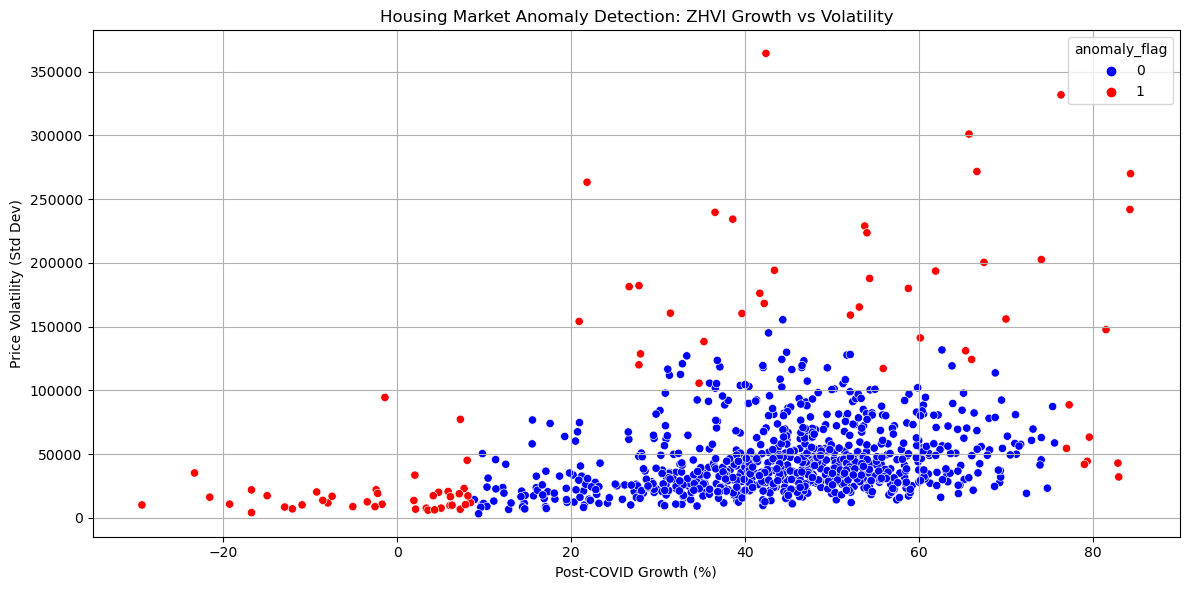

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

df = pd.read_csv("reshaped_zillow.csv")
df['Date'] = pd.to_datetime(df['Date'])

latest_month = df['Date'].max()
df_latest = df[df['Date'] == latest_month].copy()
df_march2020 = df[df['Date'] == '2020-03-31'].copy()

merged = pd.merge(df_latest, df_march2020, on="RegionName", suffixes=("_latest", "_march2020"))
merged = merged.dropna(subset=["ZHVI_latest", "ZHVI_march2020"])
merged["post_covid_growth_pct"] = (merged["ZHVI_latest"]-merged["ZHVI_march2020"])/merged["ZHVI_march2020"] * 100

grouped = df.groupby("RegionName").agg({
    "ZHVI": [np.mean, np.std]
}).reset_index()

grouped.columns = ['RegionName', 'ZHVI_mean', 'ZHVI_std']

features = pd.merge(grouped, merged[["RegionName", "post_covid_growth_pct"]], on="RegionName")

features["z_score_growth"] = zscore(features["post_covid_growth_pct"])
features["z_score_flag"] = features["z_score_growth"].apply(lambda x: 1 if np.abs(x) > 2 else 0)

iso_model = IsolationForest(contamination=0.05, random_state=42)
features["iso_score"] = iso_model.fit_predict(features[["ZHVI_mean", "ZHVI_std", "post_covid_growth_pct"]])
features["iso_flag"] = features["iso_score"].apply(lambda x: 1 if x == -1 else 0)

features["anomaly_flag"] = ((features["z_score_flag"] + features["iso_flag"]) > 0).astype(int)

anomalies = features[features["anomaly_flag"] == 1].sort_values("post_covid_growth_pct", ascending=False)
print("\n Anomalous Metro Areas Detected:\n", anomalies[["RegionName", "post_covid_growth_pct", 
                                                         "z_score_growth", "ZHVI_std"]])

plt.figure(figsize=(12, 6))
sns.scatterplot(data=features, x="post_covid_growth_pct", y="ZHVI_std",
                hue="anomaly_flag", palette={0: "blue", 1: "red"})
plt.title("Housing Market Anomaly Detection: ZHVI Growth vs Volatility")
plt.xlabel("Post-COVID Growth (%)")
plt.ylabel("Price Volatility (Std Dev)")
plt.grid(True)
plt.tight_layout()
plt.show()
